In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

style_name = 'bmh' #bmh
mpl.style.use(style_name)
np.set_printoptions(precision=4, linewidth =150)

style = plt.style.library[style_name]
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Class 03-4 toyclassifier
- 아래처럼 미리 만들어 놓은 미분 게이트를 임포트 한다.

- 주의 : 수업 중 실습으로 `Multiply` 게이트 만들기를 완성해야지 에러없이 실행됨.

In [2]:
from diff_gate_ans import Multiply, Add, Dot, Exp, Inverse, Ln, Logistic, Addn

### 강아지, 고양이 분류기

- 2주차에 예로 들었던 강아지, 고양이 이미지가 10차원 벡터로 변환되었다고 가정했을 때 개, 고양이를 분류하는 문제를 실제로 해결해보자.


- 전형적인 분류 문제로 수업의 범위를 벗어나지만 두가지 관점에서 문제를 바라 보기로 하자.
    - 합성함수를 미분하여 문제를 해결할 수 있다.
    - 합성함수의 미분 과정은 합성에 참여하는 단위 함수만 미분하는 것으로 해결할 수 있다.


- 기호
    - $\mathbf{x}_i$ : $i$번째 데이터로  $D$ 차원 벡터
    - $y_i$ : $i$번째 데이터에 대한 정답레이블
    - $\sigma(z(\mathbf{x}_i; \mathbf{w}))$ : $i$번째 데이터에 대한 분류기의 출력
    - $\mathbf{w}$ : 분류기를 조정하는 조정 파라미터


- 코스트함수<sup>cost function</sup> 또는 손실함수<sup>loss function</sup>
    - 아래 손실함수는 입력 데이터 $i$개의 손실 또는 비용으로 설정한 값을 모두 더한 것으로 0이 가장 이상적인 상태
    - 이 특정 $\mathbf{w}$에서 손실함수의 값을 순전파로 구하고, 역전파로 미분계수를 구한다. 
$$
C(\mathbf{w}) = - \sum_{i=1}^{N} y_i \log[\sigma(z(\mathbf{x}_i; \mathbf{w}))] + (1-y_i)\log[1-\sigma(z(\mathbf{x}_i; \mathbf{w}))]
$$

     
- 위 손실함수의 시그마 기호 안쪽 부분은 아래처럼 네트워크로 모델링 할 수 있다.

- 여기서 $z(\mathbf{x}_i; \mathbf{w})$부분은 $\mathbf{x}_i \cdot \mathbf{w} = \sum_{j=1}^{D} x_{ij}w_{j}$

<img src="imgs/clf-network.png" width="750"/>


In [3]:
def logistic(x):
    return 1.0 / (1 + np.exp(-x))

class Classifier :
    def __init__(self, X, y):
        self.X = X # ( 데이터 개수 N, 데이터 차원 D )
        self.N = X.shape[0]
        self.y = y # ( 데이터 개수 N, )
        
        # 우리가 구해야 하는 파라미터 w, 최초는 무작위로 설정
        self.w = np.random.randn(X.shape[1])
        
        # 코스트c 초기화
        self.cost = 0.0
        
        # 코스트 함수를 네트워크로 구성해서 이 리스트에 저장
        self.network = []
        
        
    def make_network(self):
        """
        데이터 개수 N개 만큼 단위 네트워크를 만들어 
        self.network에 추가하여 전체 네트워크를 구성
        """
        for i in range(self.N) :
            # graph for one data
            self.network.append([Dot(), Logistic(), Ln(), Multiply(), 
                                 Dot(), Logistic(), Multiply(), Add(), Ln(), Multiply(), 
                                 Add()])
        
        self.cost0 = Addn()
        self.cost1 = Multiply()
    
    
    def forward(self, w) :
        """
        위 네트워크 그림처럼 
        미리 약속된 순서대로 순전파 시킨다.
        """
        data_fwd = []
        for i in range(self.N) :
            dot01_fwd   = self.network[i][0].forward(self.X[i], w)
            sigma01_fwd = self.network[i][1].forward(dot01_fwd)
            c00_fwd     = self.network[i][2].forward(sigma01_fwd)
            c01_fwd     = self.network[i][3].forward(self.y[i], c00_fwd)

            dot02_fwd   = self.network[i][4].forward(self.X[i], w)
            sigma02_fwd = self.network[i][5].forward(dot02_fwd)
            mul01_fwd   = self.network[i][6].forward(sigma02_fwd, -1)
            add01_fwd   = self.network[i][7].forward(mul01_fwd, 1)
            c02_fwd     = self.network[i][8].forward(add01_fwd)
            c03_fwd     = self.network[i][9].forward((1-self.y[i]), c02_fwd)

            c04_fwd     = self.network[i][10].forward(c01_fwd, c03_fwd)
            
            data_fwd.append(c04_fwd)
            ######################################################
        
        # 각 데이터의 결과를 모두 더하고 
        cost0_fwd   = self.cost0.forward(data_fwd)
        # - 곱해준다.
        cost1_fwd   = self.cost1.forward(cost0_fwd, -1)
        
        self.cost   = cost1_fwd
        
        
    def backward(self) :
        """
        순전파의 역순으로 역전파 시킨다.
        """
        # backward
        cost1_bak = self.cost1.backward(1)
        cost0_bak = self.cost0.backward(cost1_bak[0])
        dw = np.zeros(X.shape[1])
        
        for i in range(self.N) :
            c04_bak     = self.network[i][10].backward(cost0_bak[i]);  
            c03_bak     = self.network[i][9].backward(c04_bak[1]);        
            c02_bak     = self.network[i][8].backward(c03_bak[1]);       
            add01_bak   = self.network[i][7].backward(c02_bak);         
            mul01_bak   = self.network[i][6].backward(add01_bak[0]);    
            sigma02_bak = self.network[i][5].backward(mul01_bak[0]); 
            dot02_bak   = self.network[i][4].backward(sigma02_bak);   
            c01_bak     = self.network[i][3].backward(c04_bak[0]);       
            c00_bak     = self.network[i][2].backward(c01_bak[1]);      
            sigma01_bak = self.network[i][1].backward(c00_bak);    
            dot01_bak   = self.network[i][0].backward(sigma01_bak);   
            
            dw += dot01_bak[1]+dot02_bak[1]
        
        return dw
    
    
    def train(self, lr=0.01, epoch=1500, verbose=False, verbose_step=100) :
        costs = []
        for i in range(epoch):
            # 함수값 계산
            self.forward(self.w)
            costs.append(self.cost)
            
            if verbose :
                if i % verbose_step == 0 : 
                    print("{}th cost:{:f}".format(i, self.cost))
            
            # 미분계수 계산
            dw = self.backward()
            
            # 스탭 이동
            self.w = self.w - lr * dw
        
        if verbose :
            print("{}th cost:{:f}".format(i+1, self.cost))
        
        return costs
    
    def gradient_bp(self, w) :
        self.forward(w)
        dw = self.backward()
        
        return dw
    
    def gradient_anal(self, w):
        """
        역전파 자동미분을 검증하기 위해 코스트함수를 손으로 미분한 코드
        
        w      : (Dx1), 미분해야하는 포인트
        X      : (NxD), D:데이터의 차원, N:데이터의 개수
        y      : (Nx1)

        return : (Dx1), 그래디언트 벡터
        """
        return np.dot( self.X.T, -self.y + logistic(np.dot(X, w)) )
###############################################################################    

In [4]:
np.random.seed(0)

# 데이터 X와 정답 레이블 y를 정의
X = np.array([[0,1,0,0,1,1,1,0,0,0],   # 개     1
              [1,0,0,1,1,1,1,0,1,0]])  # 고양이 0
y = np.array([1, 0])

# 분류기를 만들고
clf = Classifier(X,y)
clf.make_network()

#####################################################################
# 미분 계수 확인
# 임의의 w에 대해서 미분 계수를 역전파로 구해서 확인해본다.
# gradient_anal 함수값과 동일해야 제대로 계산된 것이다.
for i in range(10):
    w_ = np.random.randn(X.shape[1])
    print("Analytic   grad. : {}".format(clf.gradient_anal(w_)))
    #clf.forward(w_)
    print("Back-prob. grad. : {}".format(clf.gradient_bp(w_)))

Analytic   grad. : [ 0.9453 -0.0235  0.      0.9453  0.9218  0.9218  0.9218  0.      0.9453  0.    ]
Back-prob. grad. : [ 0.9453 -0.0235  0.      0.9453  0.9218  0.9218  0.9218  0.      0.9453  0.    ]
Analytic   grad. : [ 0.2888 -0.1802  0.      0.2888  0.1086  0.1086  0.1086  0.      0.2888  0.    ]
Back-prob. grad. : [ 0.2888 -0.1802  0.      0.2888  0.1086  0.1086  0.1086  0.      0.2888  0.    ]
Analytic   grad. : [ 0.2361 -0.1951  0.      0.2361  0.0409  0.0409  0.0409  0.      0.2361  0.    ]
Back-prob. grad. : [ 0.2361 -0.1951  0.      0.2361  0.0409  0.0409  0.0409  0.      0.2361  0.    ]
Analytic   grad. : [ 0.0516 -0.9739  0.      0.0516 -0.9224 -0.9224 -0.9224  0.      0.0516  0.    ]
Back-prob. grad. : [ 0.0516 -0.9739  0.      0.0516 -0.9224 -0.9224 -0.9224  0.      0.0516  0.    ]
Analytic   grad. : [ 0.0959 -0.2987  0.      0.0959 -0.2028 -0.2028 -0.2028  0.      0.0959  0.    ]
Back-prob. grad. : [ 0.0959 -0.2987  0.      0.0959 -0.2028 -0.2028 -0.2028  0.      0.0959

0th cost:5.846412
100th cost:0.128426
200th cost:0.059528
300th cost:0.038505
400th cost:0.028406
500th cost:0.022487
600th cost:0.018602
700th cost:0.015858
800th cost:0.013818
900th cost:0.012242
1000th cost:0.010987
1100th cost:0.009966
1200th cost:0.009118
1300th cost:0.008402
1400th cost:0.007791
1500th cost:0.007267


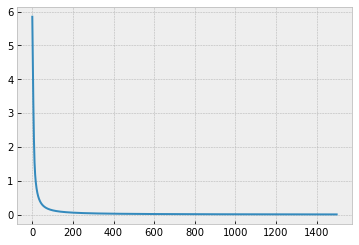

[-1.9522  4.0017  0.9787 -1.4753  1.7529 -1.0919  0.8354 -0.1514 -3.8194  0.4106]


In [5]:
# 학습시킨다.
costs = clf.train(lr=0.1, verbose=True)

plt.plot(costs)
plt.show()

# 학습된 결과
print(clf.w)

In [6]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """
   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style("../../style.css")